In [3]:
import requests
import pandas as pd
import json

![Params](nmdc_api_params.png)

GET
/dataset/{startyear}/{cruiseid}/{platform}

In [19]:
def fetch_sensordata(startyear, cruiseid, outname):
    api_url = 'http://underway-api.hi.no/apis/nmdapi/underway/v1'
    r = requests.get(f'{api_url}/dataset/{startyear}/{cruiseid}/9998', headers={"accept":"application/json"})
    with open(f'{outname}.json', 'w', encoding='utf-8') as f:
        json.dump(r.json(), f, ensure_ascii=False, indent=4)

In [21]:
fetch_sensordata(2021, 2021053, 'leg3')

In [22]:
def prep_and_separate_sensorjson(path, leg):
    f = open(path)

    data = json.load(f)

    sensors = data['sensor']
    for sensor in sensors:
        unit = sensor['unit']
        metadata = sensor['custommetadata']
        displayname = metadata[4]
        name = displayname['customvalue']
        data = sensor['timeseriesdata']

        data = { 'unit' : unit, 'sensor' : name, 'data': data }
        json.dumps(data)

        with open(f'{leg}/{name}.json', 'w', encoding='utf-8') as f:
            json.dump(data, f, ensure_ascii=False, indent=4)

In [24]:
prep_and_separate_sensorjson('leg2.json', 'Leg2')

## Prepare dataframes

In [4]:
def prep_df(file, prefix):
    f = open(file)
    data = json.load(f)
    name = data['sensor']
    df = pd.json_normalize(data['data'])
    df.dataid = pd.to_datetime(df.dataid, format='%Y-%m-%d %H:%M:%S')
    df = df.set_index('dataid')
    df = df.drop(columns=['sensortimestamp', 'geolocation'])
    df = df.rename(columns={'sensorvalue':name.split(prefix)[1]})
    
    return df


rel_sensors = ['FerryBox.C3_CDOMFluorescence.json', 'FerryBox.C3_Temperature.json', 'FerryBox.C3_CHLAFluorescence.json',
               'FerryBox.C3_Turbidity.json','FerryBox.Optode_Saturation.json', 'FerryBox.SBE45_Conductivity.json', 
               'FerryBox.SBE45_Salinity.json', 'NMEA.Trykk.json', 'NMEA.Humidity.json', 'PCO2.atm_cond.json', 'PCO2.CO2_umm.json',
               'PCO2.H2O_mmm.json', 'NMEA.Wave_Height.json', 'NMEA.Wind_Angle.json', 'NMEA.Wind_Speed.json']

append_str = 'BlueInsight_'
blueinsight_sensors = [append_str + sub for sub in rel_sensors]

def combine_sensordfs(sensors, leg, prefix):
    prev_df = pd.DataFrame(columns=['dataid']) #empty dataframe with column dataid
    for sensor in sensors:
        df = prep_df(f'{leg}/{sensor}', prefix)
        new_df = pd.merge(df,prev_df,on='dataid', how="outer")
        prev_df = new_df

    return new_df
    

In [5]:
df = combine_sensordfs(blueinsight_sensors, 'Leg2', 'BlueInsight_')

In [12]:
df.fillna(0)
df.describe()

,NMEA.Wind_Speed,NMEA.Wind_Angle,NMEA.Wave_Height,PCO2.H2O_mmm,PCO2.CO2_umm,PCO2.atm_cond,NMEA.Humidity,NMEA.Trykk,FerryBox.SBE45_Salinity,FerryBox.SBE45_Conductivity,FerryBox.Optode_Saturation,FerryBox.C3_Turbidity,FerryBox.C3_CHLAFluorescence,FerryBox.C3_Temperature,FerryBox.C3_CDOMFluorescence
count,50677.000000,50677.000000,1507.000000,17010.000000,17012.000000,17012.000000,36748.000000,50656.000000,45254.000000,45254.000000,45254.000000,45254.000000,45253.000000,45254.000000,45253.000000
mean,12.138779,171.896708,3.567863,0.303002,410.440782,9.966375,74.668532,1012.361451,28.209049,4.632713,93.935444,101.925784,-0.487576,31.327096,-0.161698
std,5.295910,66.096527,51.474428,1.030524,91.338552,0.010608,5.367950,2.039211,13.821786,2.252103,3.006209,204.667898,0.052100,4.724571,0.107990
min,0.242857,1.800000,0.170000,-1.450000,-0.340000,9.920000,58.916668,1007.371643,0.000000,-0.066000,81.449997,0.490000,-0.550000,23.900000,-0.460000
25%,8.340000,128.166672,1.070000,0.140000,417.857491,9.970000,70.820000,1010.844299,33.334000,5.597000,93.430000,0.930000,-0.510000,28.870001,-0.240000
50%,11.483334,162.000000,2.240000,0.320000,428.925003,9.970000,73.983330,1012.106689,34.492001,5.728000,95.099998,1.110000,-0.510000,29.740000,-0.160000
75%,15.633333,200.833328,3.060000,0.410000,439.799988,9.970000,77.866669,1013.581482,35.820000,5.808000,95.730003,1.250000,-0.500000,30.270000,-0.090000
max,32.242859,357.166656,1999.579956,8.840000,502.529999,9.980000,89.733330,1018.233337,36.745998,5.957000,110.480003,806.920000,4.620000,44.700001,0.460000


In [7]:
import seaborn as sn
import matplotlib.pyplot as plt

def corr_matrix(df):
    corrMatrix = df.corr()
    plt.figure(figsize=(30, 20))
    heatmap = sn.heatmap(corrMatrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Correlation Heatmap Sensors', fontdict={'fontsize':18}, pad=12);
    plt.show()
    return heatmap

def save_matrix_png(heatmap, outname):
    figure = heatmap.get_figure()   
    figure.savefig(f'{outname}.png', dpi=300, bbox_inches='tight')


In [8]:
df.to_csv('leg2_prepped.csv', index = False)

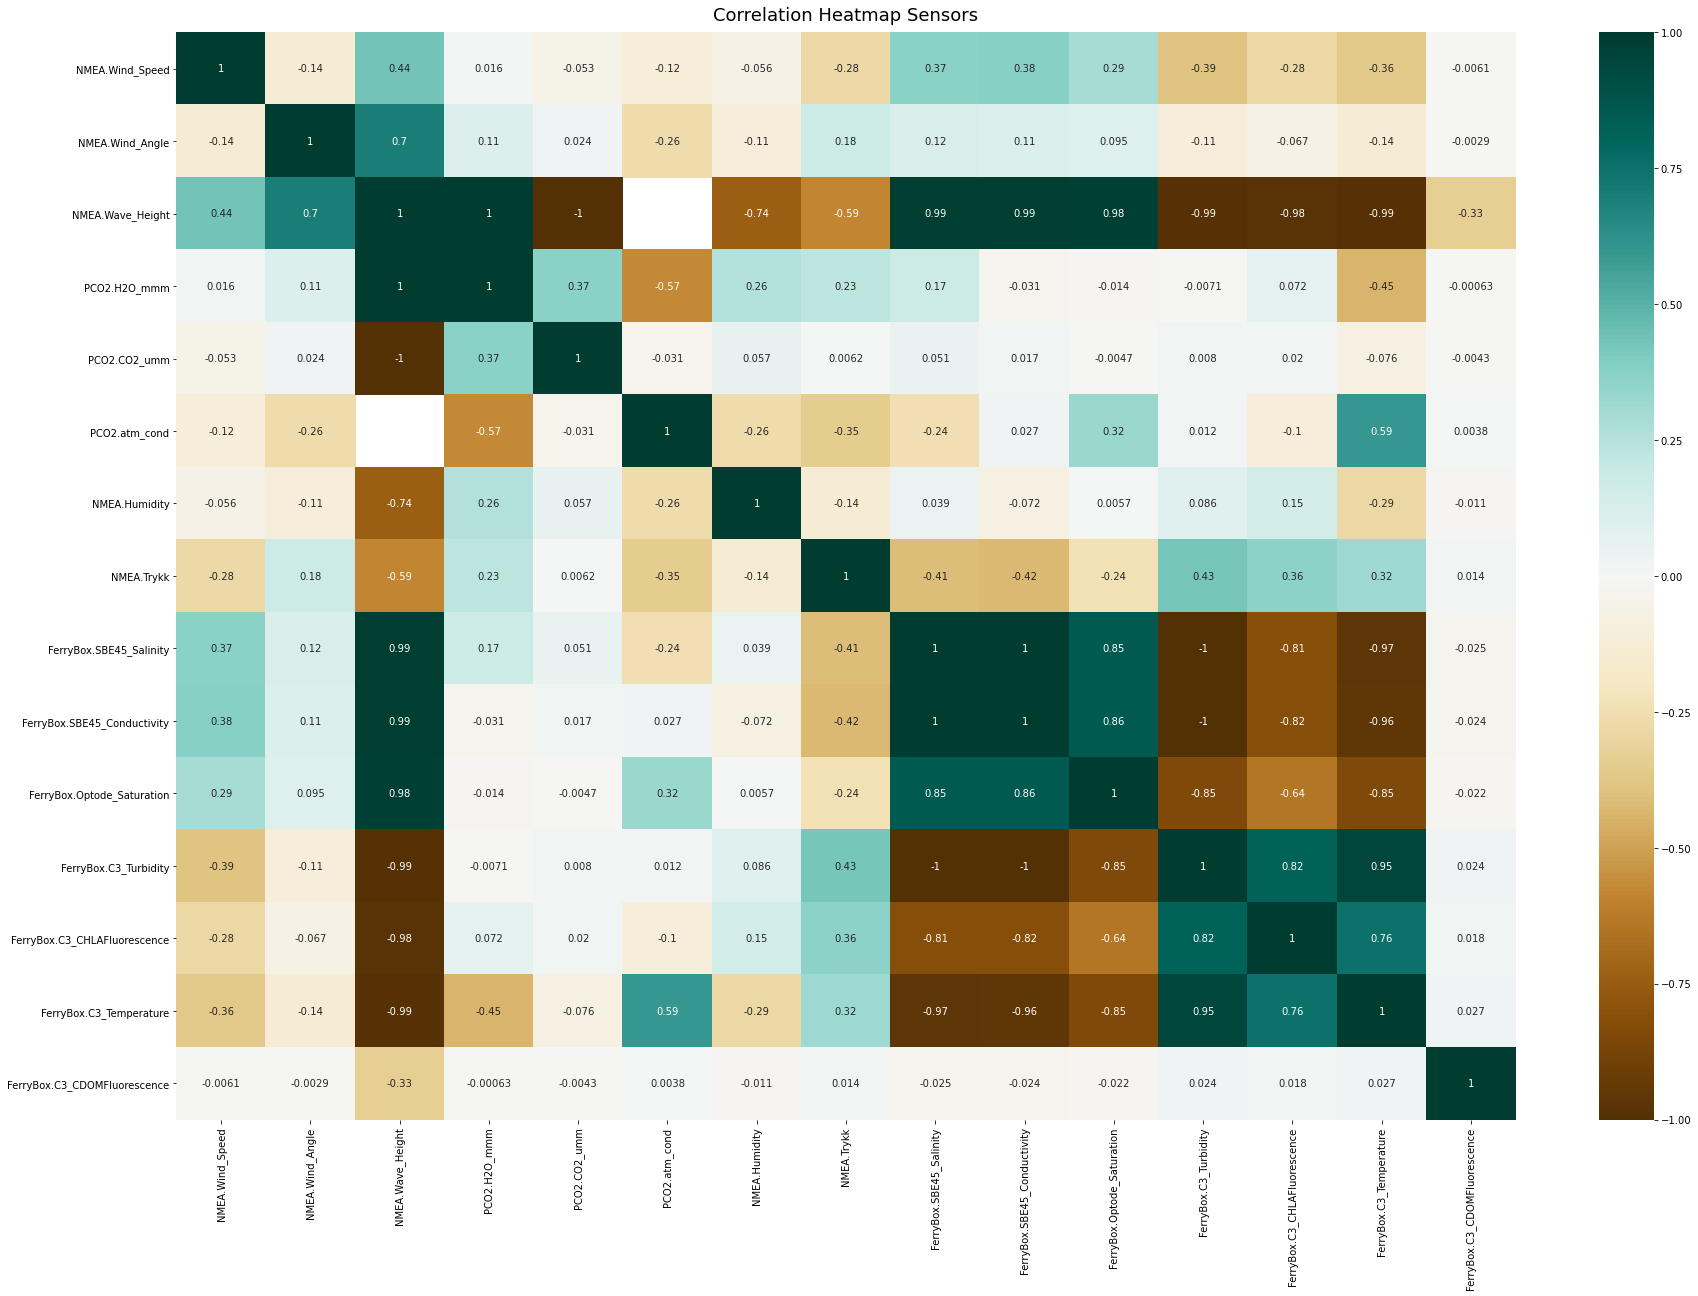

<AxesSubplot:title={'center':'Correlation Heatmap Sensors'}>

In [9]:
corr_matrix(df)